In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback

import seaborn as sns

2023-10-09 06:03:05.156247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}


with open('mushroom_train.pkl', 'rb') as f:
    data = pickle.load(f)
    y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    X = np.array([data[i]["images"].numpy() for i in range(len(data))])

with open('mushroom_test.pkl', 'rb') as f:
    data = pickle.load(f)
    ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

## Specify learning algorithms

In [63]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [64]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-15,
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss_new":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = np.exp(np.log(2 * yy - 1) + np.log(np.dot(xx, theta)))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2) 
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            print(f"pz: {pz}, zeta: {zeta}, omega: {omega}, u: {u}")
            grad = np.exp(np.log(zeta) + np.log(grad) - np.log(pz))
        elif mode == "polyak_absloss_old":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_absloss_old_w_clip":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = zeta * grad / pz
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)

            zeta_log = np.log(kappa) + log_ratio(u) - 2 * np.log(np.linalg.norm(xx))

            zeta_log = min(zeta_log, np.log(kappa0))
            zeta = np.exp(zeta_log)
            
            pz = np.exp(np.log(omega) - np.logaddexp(0, -u))
            #pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [12]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [13]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [14]:
hyperparam_per_algo

{'absloss': {'eta': 3009.8965432222953, 'omega': 867721.9697499737},
 'polyak_absloss': {'eta': 3006.748421206188,
  'kappa': 38.57368926766347,
  'kappa0': 0.5874954007831434,
  'omega': 0.5302572115259397},
 'polyak_exponent': {'eta': 3008.3887872213713,
  'kappa': 18.332404361279764,
  'kappa0': 0.49948861978867337,
  'polyakexp': 0.9985258897467942},
 'random': {'eta': 2982.363013541261, 'pz0': 0.5}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [15]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6881465830034659, train loss: 0.6931471805599453, ||theta||_1: 1746.086071240654
loss: 0.2637064527219823, train loss: 0.058693646426842175, ||theta||_1: 222646.27484928697
loss: 0.156654019778123, train loss: -0.0, ||theta||_1: 308392.2504694787
loss: 0.1029981991961254, train loss: 0.06072753145353053, ||theta||_1: 361568.5931334715
loss: 0.07041149576134047, train loss: -0.0, ||theta||_1: 404015.8669111368
loss: 0.04922317305514102, train loss: 0.06455820367626271, ||theta||_1: 437084.6039329934
loss: 0.04020565225638374, train loss: -0.0, ||theta||_1: 453458.19812616357
loss: 0.034013635625203334, train loss: 0.027977790854926902, ||theta||_1: 467862.8011514776
loss: 0.029007342106006008, train loss: 0.0005499298465424299, ||theta||_1: 478005.9098167024
loss: 0.025164052820969257, train loss: 1.0624008345375904e-09, ||theta||_1: 484836.67233370745
loss: 0.022693344499133634, train loss: -0.0, ||theta||_1: 491024.5

In [16]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [17]:
absloss_mean_sampling_prob

0.4977854494544942

In [18]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.688169498994797, train loss: 0.6931471805599453, ||theta||_1: 1730.1134582362629
loss: 0.4147539641894076, train loss: 0.05958277919299843, ||theta||_1: 122194.80032595895
loss: 0.2935029976003239, train loss: -0.0, ||theta||_1: 197015.1161365264
loss: 0.2137532168245254, train loss: 0.15256982986634895, ||theta||_1: 251441.68330672526
loss: 0.17125115524353393, train loss: -0.0, ||theta||_1: 285134.9390442286
loss: 0.1350602522095612, train loss: 0.030495042481089182, ||theta||_1: 319005.8240630493
loss: 0.10575708970488316, train loss: 0.0967921617049605, ||theta||_1: 348492.98272700264
loss: 0.09108323600990671, train loss: 6.474569289494853e-07, ||theta||_1: 367500.4752818908
loss: 0.08061564746842072, train loss: 0.0031107882819759094, ||theta||_1: 379475.7950292882
loss: 0.06740434134988092, train loss: -0.0, ||theta||_1: 394036.11430456216
loss: 0.0606640937463399, train loss: 4.5345993636992175e-10, ||theta||_1

In [19]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6881465830034659, train loss: 0.6931471805599453, ||theta||_1: 1746.086071240654
loss: 0.4022496703780511, train loss: 0.12207100804244139, ||theta||_1: 138309.20515628794
loss: 0.2749262045491838, train loss: 0.03210695531318869, ||theta||_1: 218333.5090646318
loss: 0.2099381366654838, train loss: 0.3079662393763121, ||theta||_1: 265718.19039258047
loss: 0.15721573733905997, train loss: 0.03029575754626626, ||theta||_1: 309243.58235102554
loss: 0.12903058241405252, train loss: 0.025915197116533967, ||theta||_1: 339003.6091751181
loss: 0.10215036710291484, train loss: 0.07892810251985467, ||theta||_1: 368032.0823412
loss: 0.08444186872481498, train loss: 0.06358853939552389, ||theta||_1: 389840.71834265406
loss: 0.07521019864374535, train loss: 0.0003886774046003307, ||theta||_1: 398727.1184588582
loss: 0.06316035966148927, train loss: 0.001294214887775188, ||theta||_1: 417363.6674379364
loss: 0.0524227391184302, train

In [20]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.42549586049224736, train loss: 0.12422436501973616, ||theta||_1: 126366.01431454335
loss: 0.31281831911095465, train loss: -0.0, ||theta||_1: 196921.7396962011
loss: 0.24045896749484852, train loss: 0.1097526730363595, ||theta||_1: 249141.28530458352
loss: 0.1915501151824379, train loss: 0.0321420773479898, ||theta||_1: 293522.0771974801
loss: 0.15492754812627443, train loss: 0.16345296491667102, ||theta||_1: 329209.811396967
loss: 0.14120050102286308, train loss: 0.025432608444279303, ||theta||_1: 342776.56773367577
loss: 0.12292303354118876, train loss: 0.06006813694765831, ||theta||_1: 361032.3826148724
loss: 0.11101788056599356, train loss: 0.03310309202795701, ||theta||_1: 372896.3787707616
loss: 0.09728780707822411, train loss: 0.11962954644375685, ||theta||_1: 392238.7502535567
loss: 0.09022901056432635, train loss: 0.09646849624940038, 

In [21]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

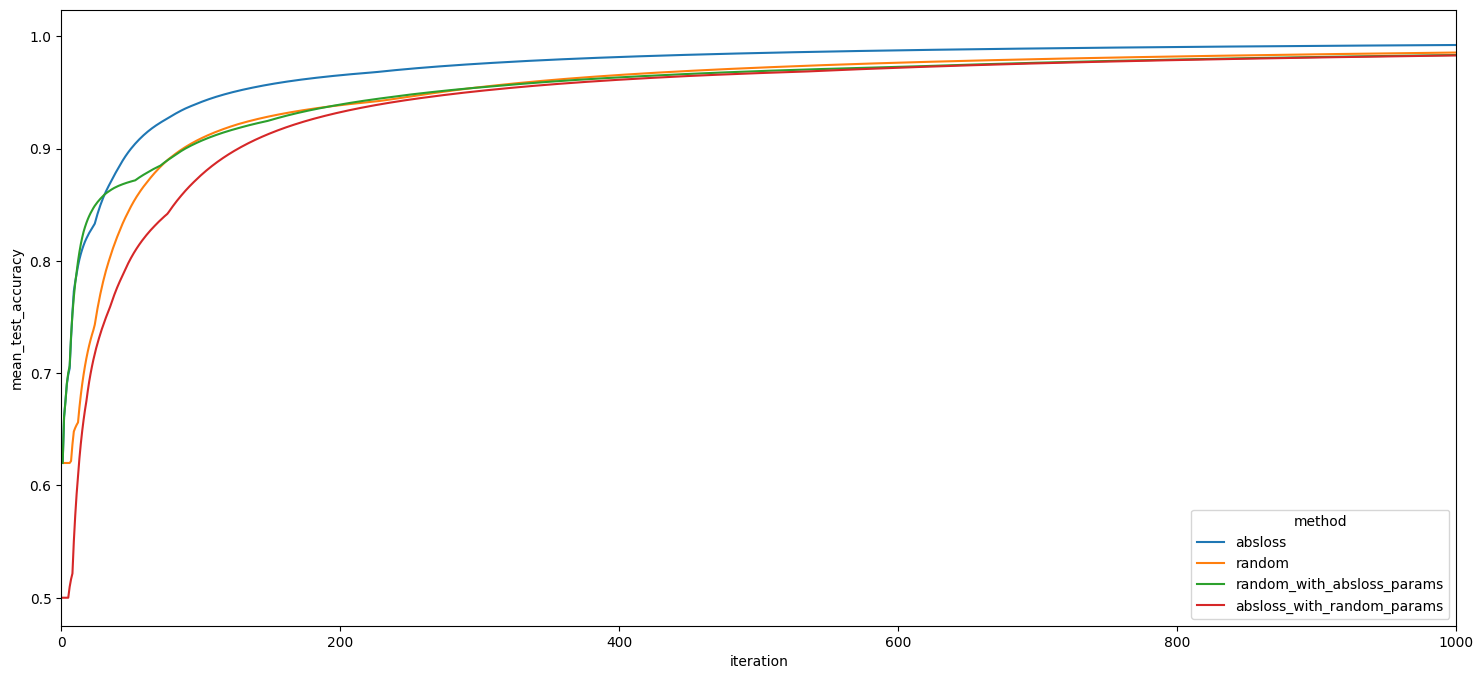

In [22]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

(0.0, 1000.0)

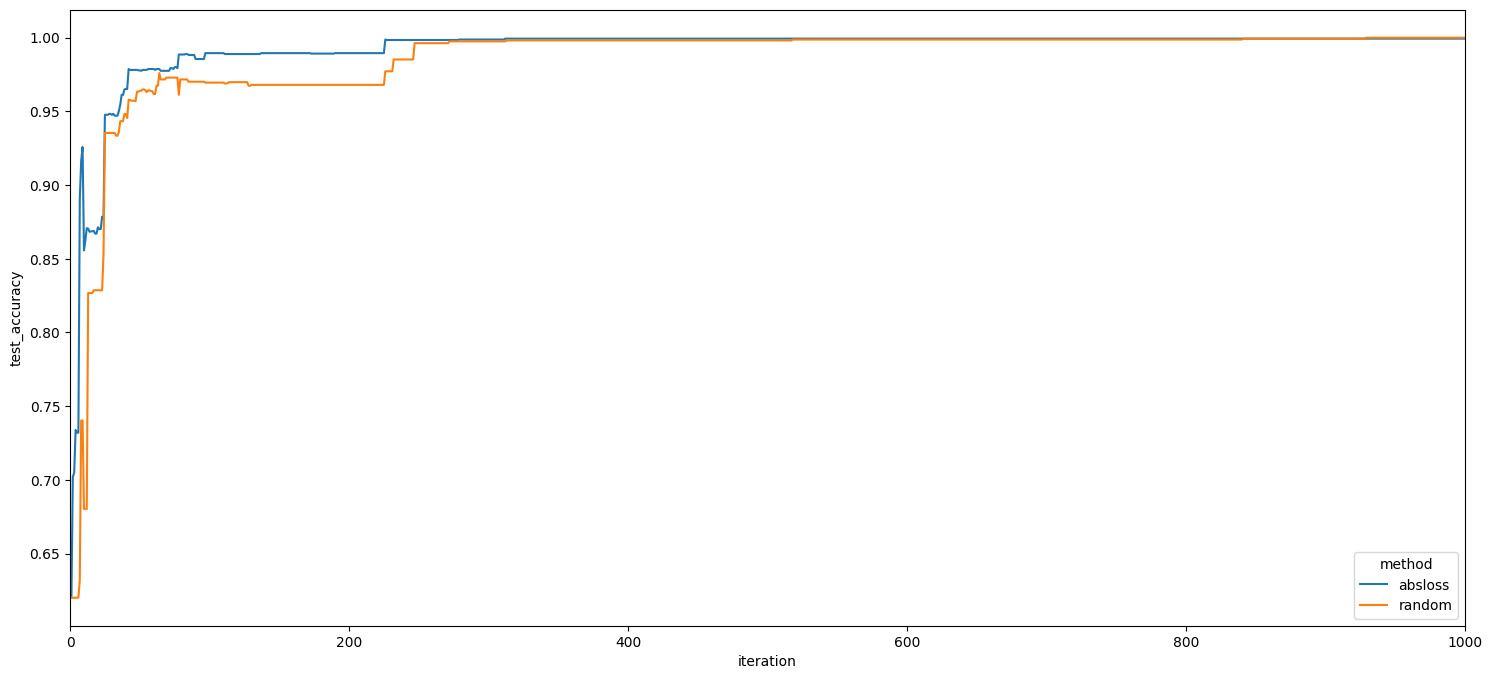

In [23]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

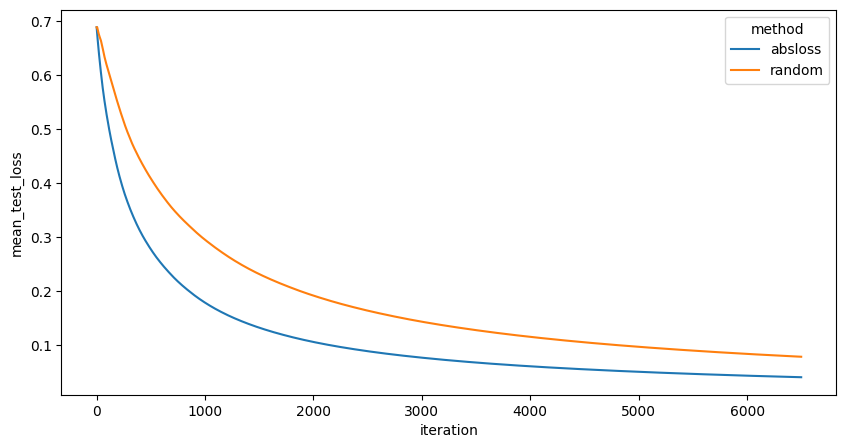

In [24]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

Text(0, 0.5, 'average cross entropy loss')

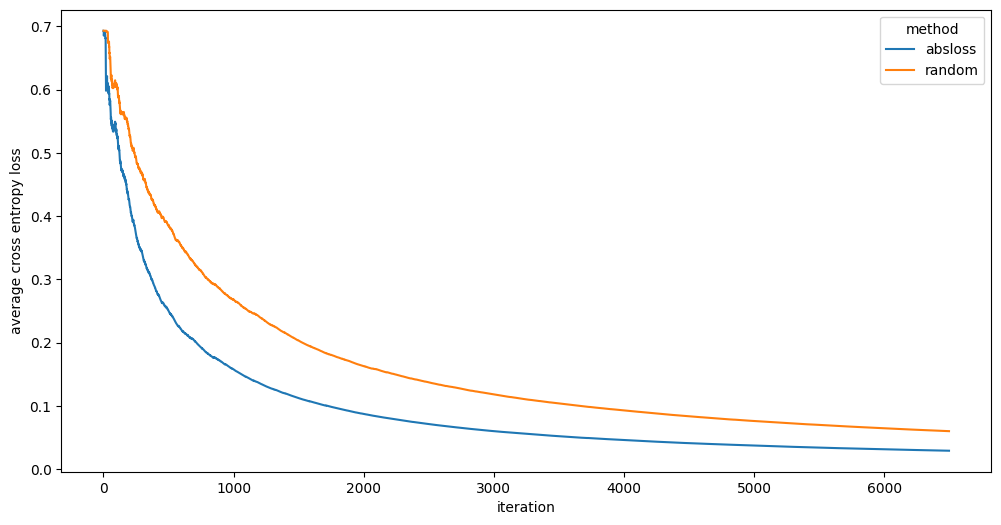

In [25]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

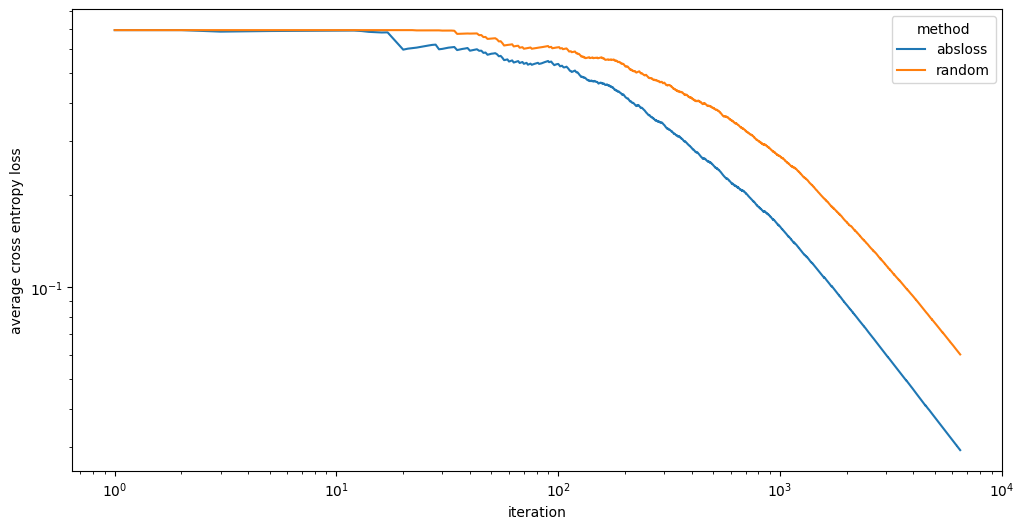

In [26]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [27]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.4201215640009834, train loss: 0.07912806455313087, ||theta||_1: 126314.8726643736
loss: 0.29439764281570746, train loss: 0.07161902274945091, ||theta||_1: 198258.01968519794
loss: 0.21184859499702233, train loss: 0.08483447013335992, ||theta||_1: 257125.55384721726
loss: 0.1626929209704135, train loss: -0.0, ||theta||_1: 297833.16594645183
loss: 0.12729673899134994, train loss: 0.11703186233176005, ||theta||_1: 334057.1483614541
loss: 0.10938258135491305, train loss: -0.0, ||theta||_1: 355925.8776176999
loss: 0.09178883947193137, train loss: 2.691318812480594e-07, ||theta||_1: 379191.94031571894
loss: 0.08116492505836266, train loss: 1.1475865572302797e-06, ||theta||_1: 394380.3467188066
loss: 0.07104423462752638, train loss: -0.0, ||theta||_1: 406017.76710906695
loss: 0.06373826484119464, train loss: 7.216449660063778e-14, ||theta||_1:

In [28]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[6.634062413244553, 3.3170312066222767, 1.9970517794935885, 0.9985258897467942]

In [29]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

/var/folders/s7/8k0y__9d35n2x08wq1cqf9j00000gn/T/ipykernel_92140/4108679546.py:5: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-x))


In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [30]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [31]:
empirical_pzs

[0.01000000000000002,
 0.10000000000000009,
 0.25000000000000006,
 0.5000000000000001]

In [32]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [33]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [34]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs
polyak_exponent  1.0         0.50     0.056430
                 2.0         0.25     0.082401
                 3.3         0.10     0.146566
                 6.6         0.01     0.371134
random           1.0         0.50     0.056491
                 2.0         0.25     0.109863
                 3.3         0.10     0.205682
                 6.6         0.01     0.567224
Name: train_loss, dtype: float64

In [35]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs
polyak_exponent  1.0         0.50     0.056430
                 2.0         0.25     0.082401
                 3.3         0.10     0.146548
                 6.6         0.01     0.371134
random           1.0         0.50     0.056491
                 2.0         0.25     0.109863
                 3.3         0.10     0.205659
                 6.6         0.01     0.567162
Name: mean_train_loss, dtype: float64

Polyak exp value 6.6 has rows (12998, 16)
Polyak exp value 3.3 has rows (12998, 16)
Polyak exp value 2.0 has rows (12998, 16)
Polyak exp value 1.0 has rows (12998, 16)


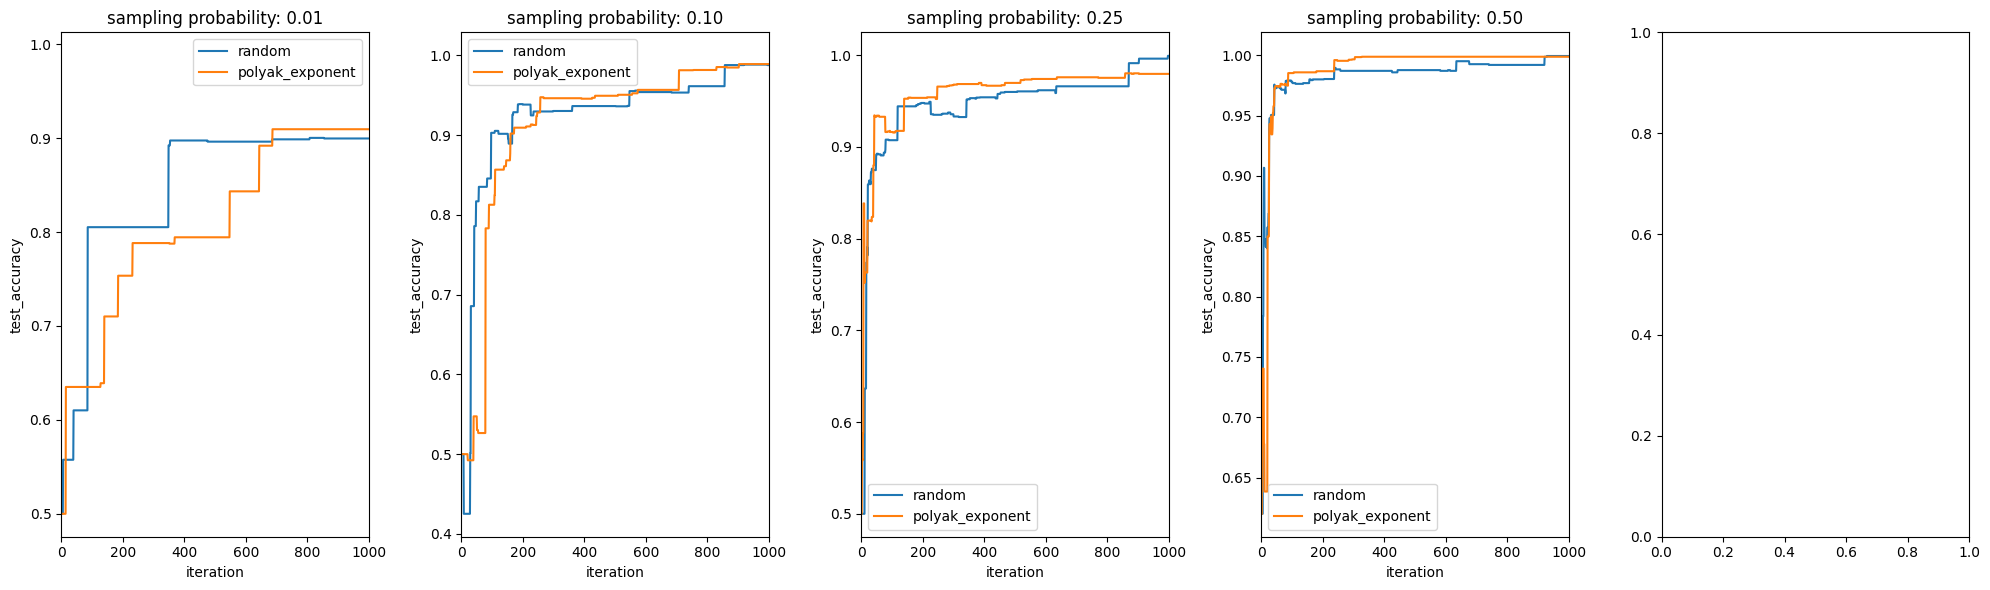

In [36]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 6.6 has rows (12998, 16)
Polyak exp value 3.3 has rows (12998, 16)
Polyak exp value 2.0 has rows (12998, 16)
Polyak exp value 1.0 has rows (12998, 16)


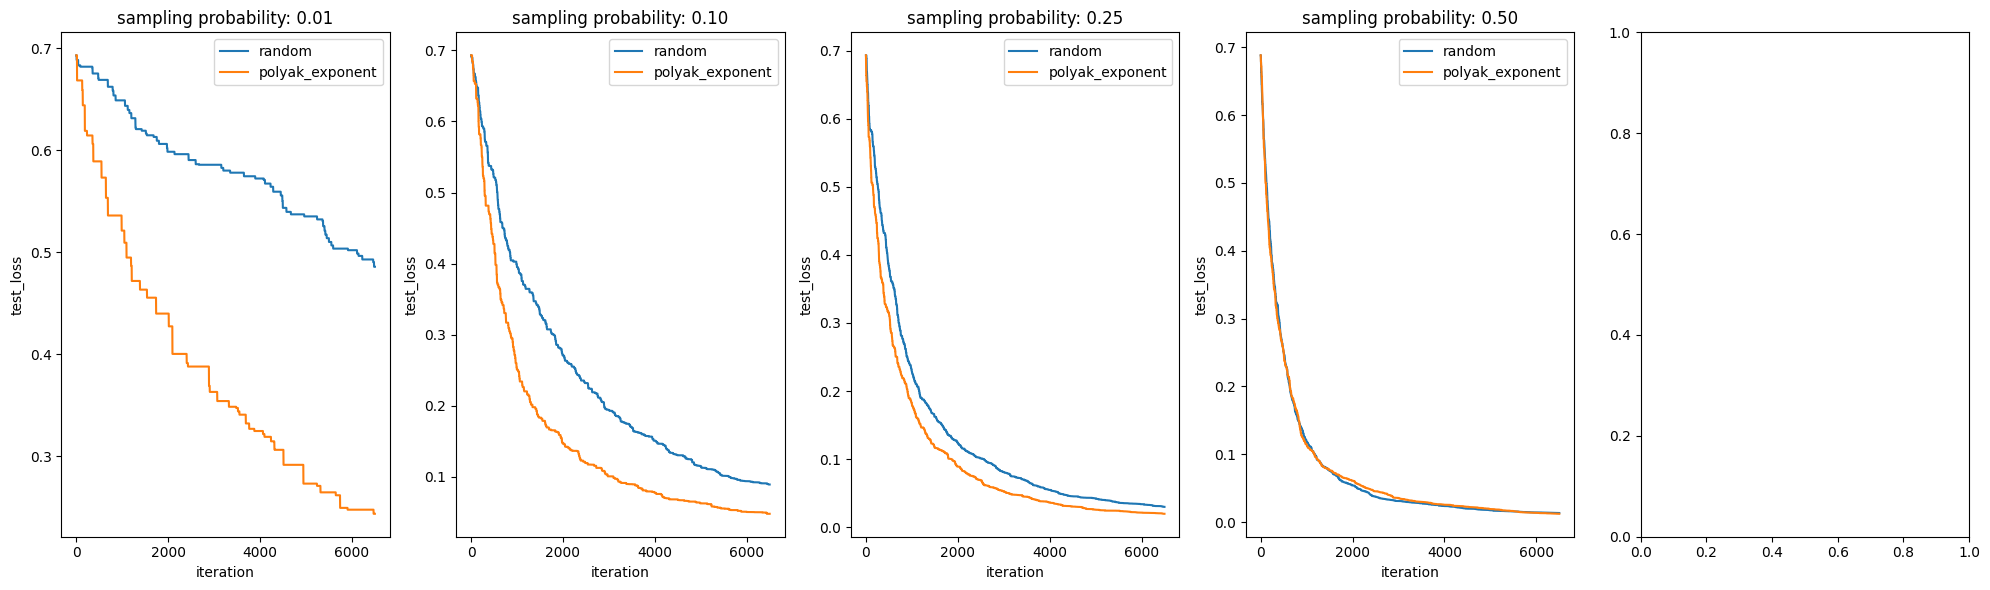

In [37]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

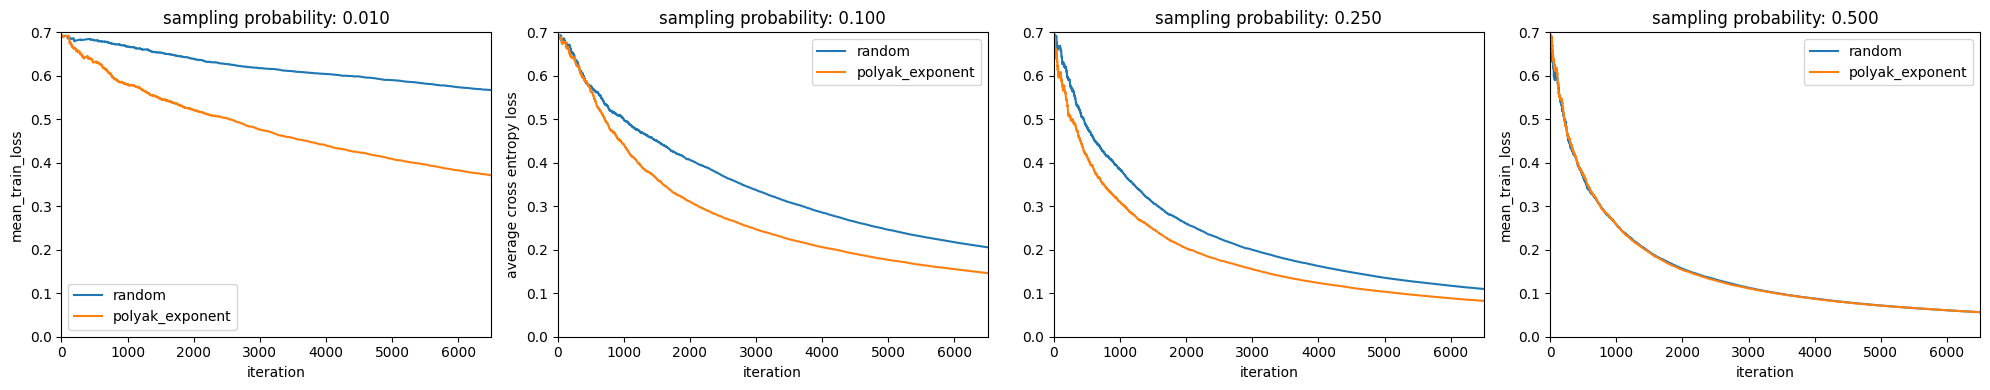

In [48]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 0.7))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[1].set_ylabel("average cross entropy loss")
axs[2].set_ylabel("")

axs[2].get_legend().remove()

f.tight_layout()

0.01000000000000002
Polyak exp value 6.6 has rows (12998, 16)
0.10000000000000009
Polyak exp value 3.3 has rows (12998, 16)
0.25000000000000006
Polyak exp value 2.0 has rows (12998, 16)
0.5000000000000001
Polyak exp value 1.0 has rows (12998, 16)


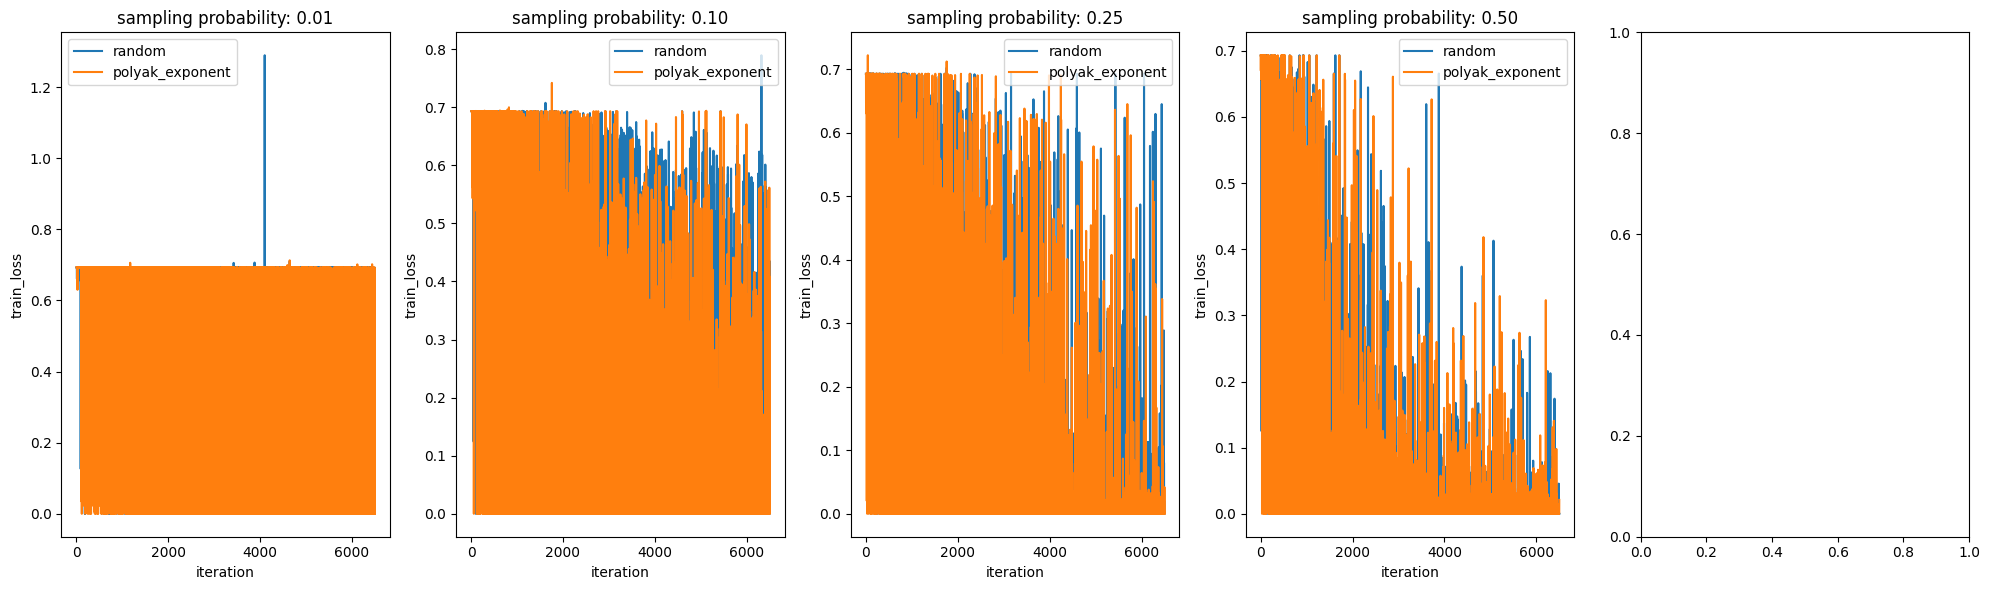

In [39]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.01000000000000002
Polyak exp value 6.6 has rows (12998, 16)
0.10000000000000009
Polyak exp value 3.3 has rows (12998, 16)
0.25000000000000006
Polyak exp value 2.0 has rows (12998, 16)
0.5000000000000001
Polyak exp value 1.0 has rows (12998, 16)


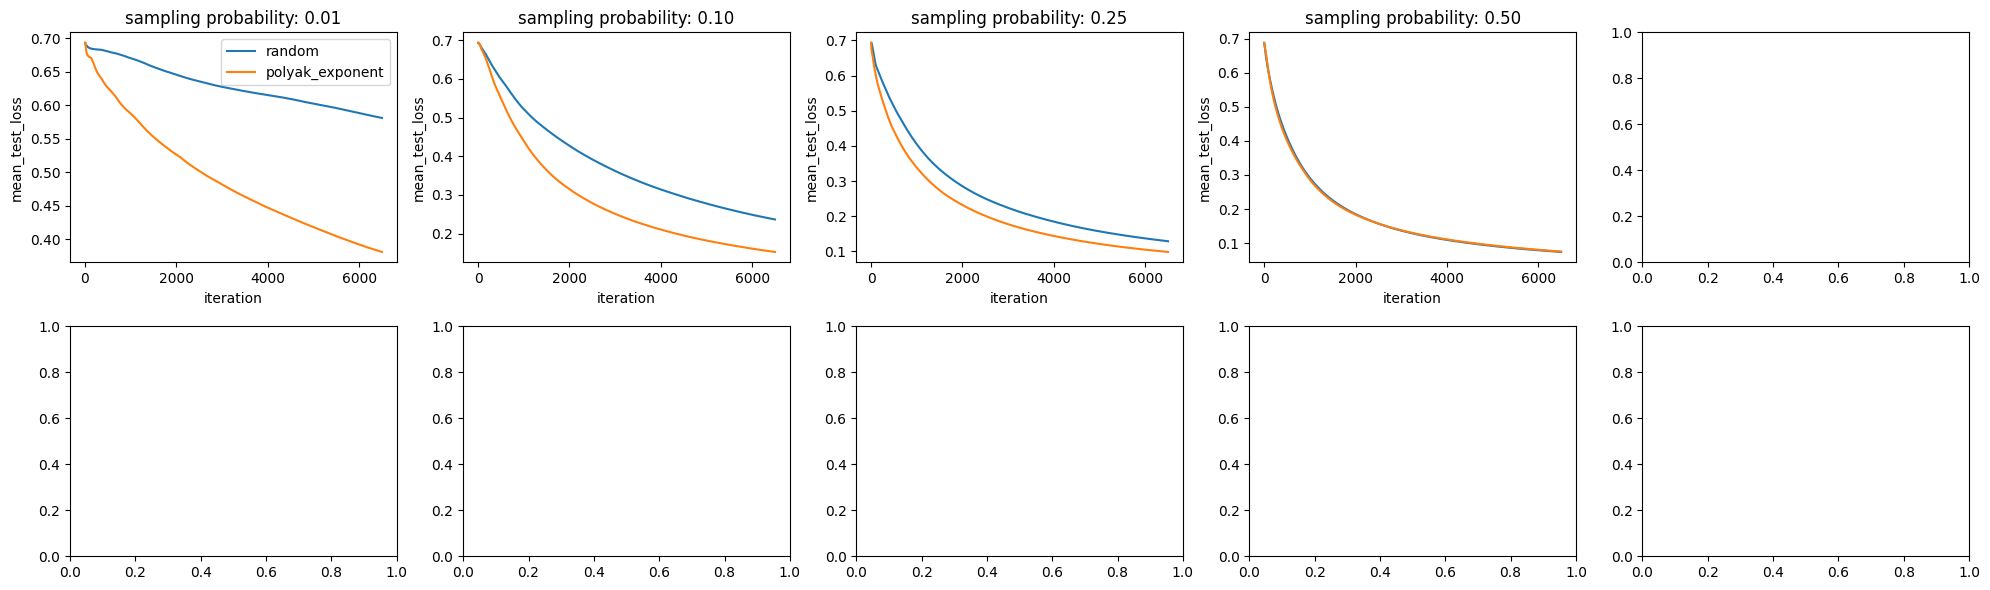

In [40]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [41]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 6499 iterations with d=6499
loss: 0.6861516211694688, train loss: 0.6931471805599453, ||theta||_1: 3865.084808075013
loss: 0.4421803235000735, train loss: 0.010723049102611685, ||theta||_1: 181155.95538082012
loss: 0.30286825302172343, train loss: 0.00032025157027574684, ||theta||_1: 297832.05747938657
loss: 0.2097360215625603, train loss: 0.02677611181847992, ||theta||_1: 399187.31282459234
loss: 0.16457357739658912, train loss: 0.021563536578414453, ||theta||_1: 454085.02007207996
loss: 0.13666734196513575, train loss: 0.01845292163797072, ||theta||_1: 494085.5812032243
loss: 0.11321084270120599, train loss: 0.618679999804873, ||theta||_1: 521526.95345728094
loss: 0.10032281591540121, train loss: 0.34886846759268936, ||theta||_1: 541300.6963788504
loss: 0.08723790168197802, train loss: 3.437728630486577e-05, ||theta||_1: 563222.0003947392
loss: 0.07509534573684207, train loss: -0.0, ||theta||_1: 583611.2541747071
loss: 0.06508336933809833, trai

In [50]:
results_polyak_absloss_old = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss_old", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss_old: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0


/var/folders/s7/8k0y__9d35n2x08wq1cqf9j00000gn/T/ipykernel_92140/1107115515.py:85: RuntimeWarning: invalid value encountered in divide
  grad = zeta * grad / pz


loss: 0.4651886333657522, train loss: 0.6908432268615902, ||theta||_1: 179264.7296915918
loss: 0.34055172320709703, train loss: 0.5422535628396399, ||theta||_1: 296623.5396435714
loss: 0.24923658282513259, train loss: 0.4957038786461874, ||theta||_1: 402313.28204064636
loss: 0.19736837283792455, train loss: 0.44359678381337914, ||theta||_1: 472218.2347915096
loss: 0.16476621924821494, train loss: 0.0003230707144380866, ||theta||_1: 533235.2681244552
loss: 0.15295560258425858, train loss: -0.0, ||theta||_1: 563386.1949353464
loss: 0.12619353594265284, train loss: 0.48173017409927055, ||theta||_1: 617886.3121301576
loss: 0.11364019525808644, train loss: 0.471392047595508, ||theta||_1: 649989.2658279281
loss: 0.10239496682423603, train loss: 0.00021183294853023094, ||theta||_1: 680952.2287569287
loss: 0.09130383857021065, train loss: 0.022241169814371797, ||theta||_1: 708579.3451262991
loss: 0.08757483816011295, train loss: 6.150460299739961e-05, ||theta||_1: 720248.6409421344
loss: 0.084

In [65]:
results_polyak_absloss_old_w_clip = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss_old_w_clip", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss_old_w_clip: 6499 iterations with d=6499
loss: 0.6861516211694688, train loss: 0.6931471805599453, ||theta||_1: 3865.084808075013
loss: 0.48729260881188535, train loss: 0.011272963045700989, ||theta||_1: 155517.67396208274
loss: 0.36965178514771946, train loss: 0.00926042958652051, ||theta||_1: 264047.99730937905
loss: 0.283347475045788, train loss: 0.5110417600185237, ||theta||_1: 369690.8284340024
loss: 0.23174160629111898, train loss: -0.0, ||theta||_1: 443435.529356134
loss: 0.18392462329011322, train loss: 0.5834056792601123, ||theta||_1: 524691.9409849946
loss: 0.1698265293341266, train loss: 0.009359359259105728, ||theta||_1: 548641.9471491507
loss: 0.1472640658482803, train loss: 0.005223976888235584, ||theta||_1: 606095.7552379702
loss: 0.13156138132666323, train loss: 0.34186608356518816, ||theta||_1: 641211.9427912519
loss: 0.12016565189992798, train loss: 0.006547536299911289, ||theta||_1: 671551.4186979851
loss: 0.10825484092133558, tr

In [67]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
        "polyak_absloss_old_w_clip": results_polyak_absloss_old_w_clip,
        "polyak_absloss_old": results_polyak_absloss_old
    }
)

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

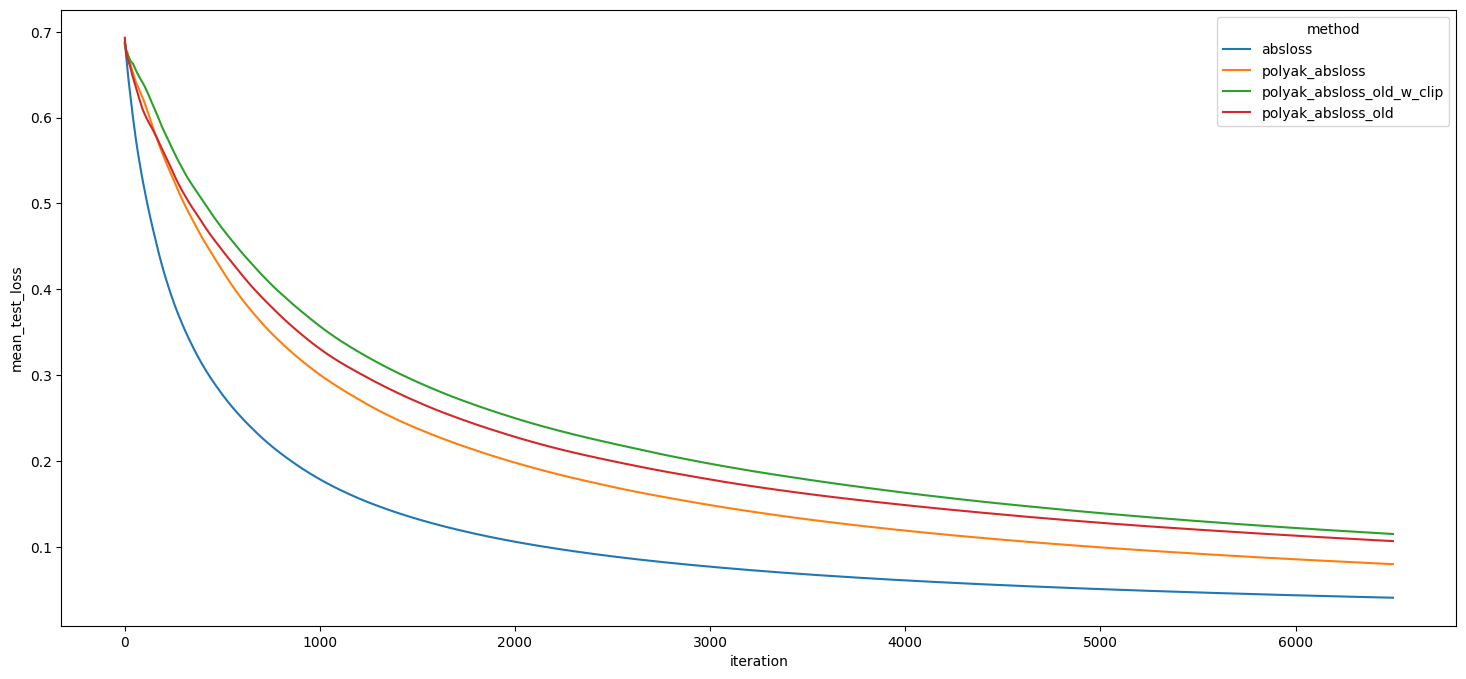

In [68]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

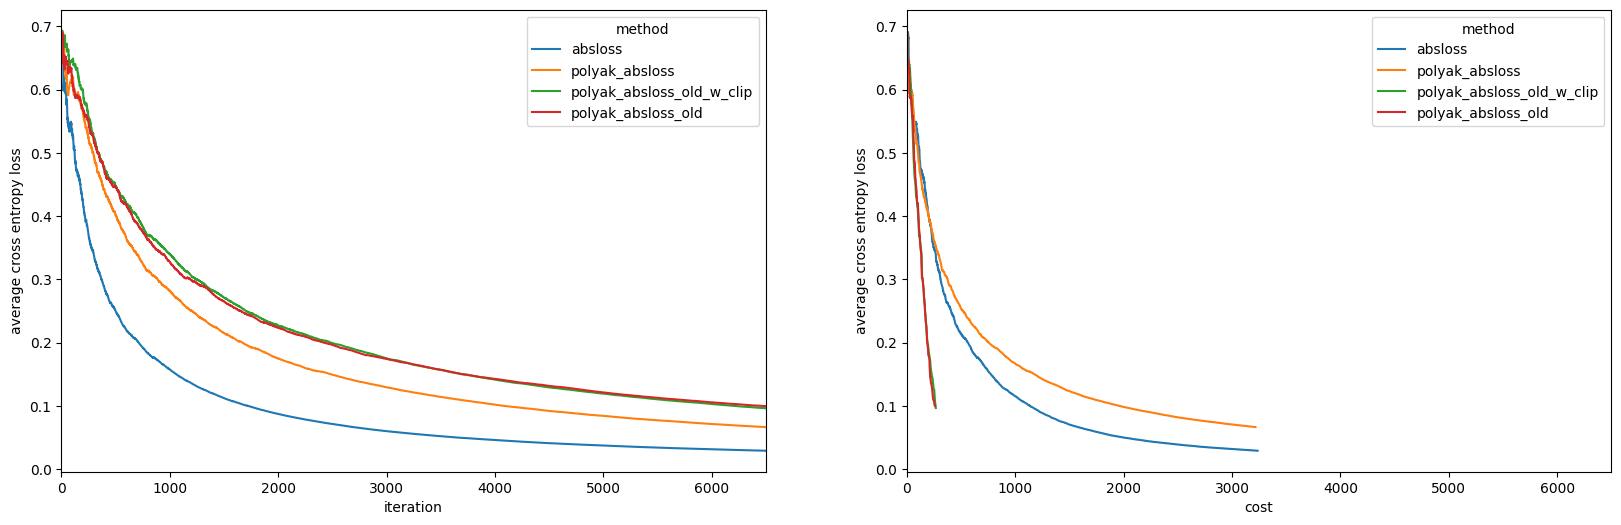

In [69]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

<Axes: xlabel='iteration', ylabel='mean_test_accuracy'>

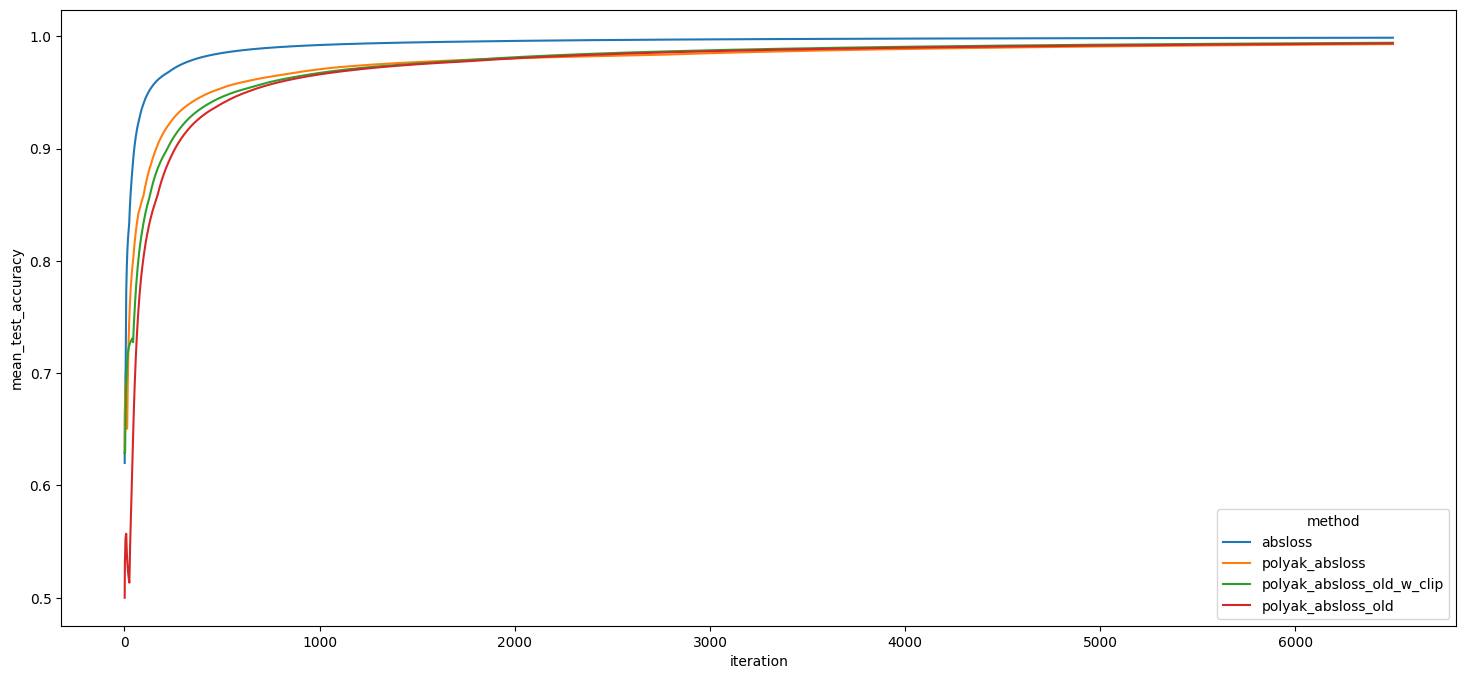

In [70]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

In [71]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

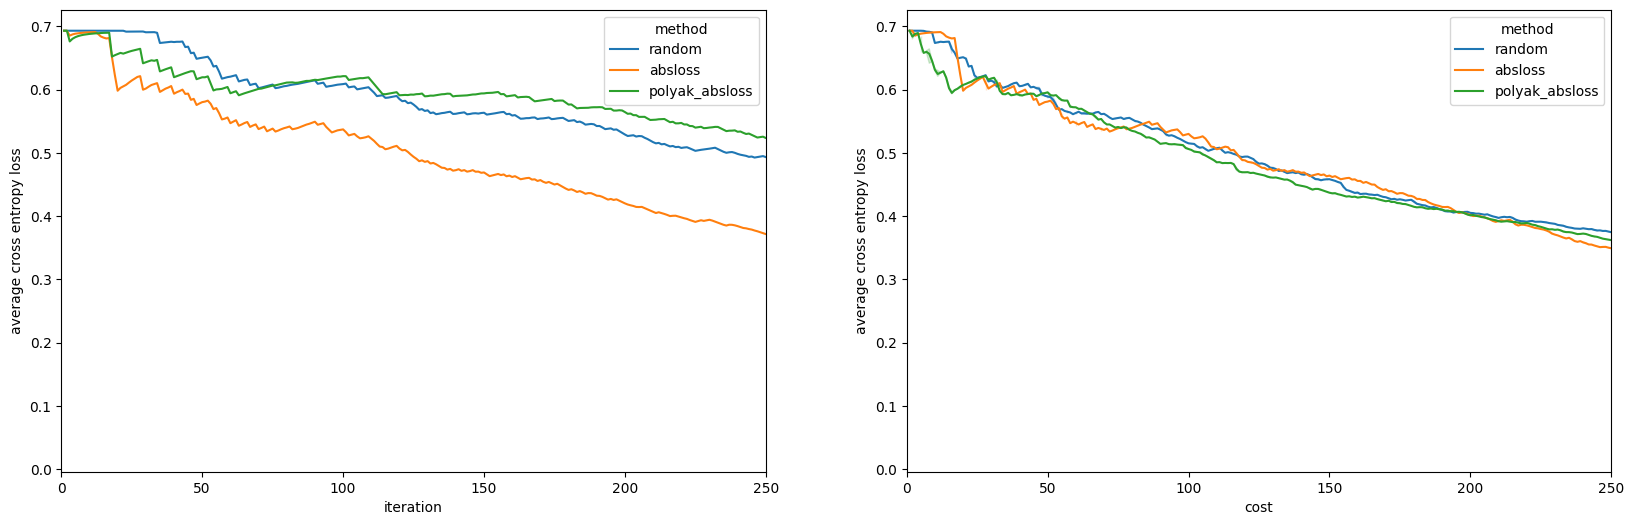

In [72]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 250))